## Imports :

In [85]:
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
)
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

## SNCF Data Loading and Preparation

### Description
This section initializes the processing of railway data for the TARDIS project. It loads the cleaned dataset and performs necessary preprocessing operations.

### Processing Steps

- Libraries Import

- Dataset Loading
    -> Source: `cleaned_dataset.csv` with separator: comma (`,`)

- Data Cleaning

- Variables Preparation
    -> Target variable (y): "Average delay of late trains at arrival" and Features (X): All other columns

In [86]:
df = pd.read_csv("cleaned_dataset.csv", sep=",")
df = df.drop(
    columns=[
        "Date",
    ]
)

X = df.drop("Average delay of late trains at arrival", axis=1)
y = df["Average delay of late trains at arrival"]

df.head(5)

,Season,Month,Year,Service,Departure station,Arrival station,Average journey time,Number of scheduled trains,Number of cancelled trains,Number of trains delayed at departure,...,Pct delay due to traffic management,Pct delay due to rolling stock,Pct delay due to station management and equipment reuse,"Pct delay due to passenger handling (crowding, disabled persons, connections)",Punctuality,Arrival Delay Gap,Departure Delay Gap,Number of trains non delayed,Percent of trains delayed,Route
0,Winter,1,2018,National,AIX EN PROVENCE TGV,PARIS LYON,188.0,402,0,117,...,8.571429,190.420084,0.000000,2.857143,94.661809,31.623294,-31.623294,365,9.203980,AIX EN PROVENCE TGV → PARIS LYON
1,Spring,3,2018,National,AIX EN PROVENCE TGV,PARIS LYON,188.0,396,8,148,...,11.111111,190.420084,5.555556,2.777778,93.552979,29.365923,-29.365923,349,9.848485,AIX EN PROVENCE TGV → PARIS LYON
2,Spring,5,2018,National,AIX EN PROVENCE TGV,PARIS LYON,188.0,410,10,47,...,198.761036,190.420084,7.692308,1.923077,92.792611,33.073714,-33.073714,348,12.682927,AIX EN PROVENCE TGV → PARIS LYON
3,Summer,6,2018,National,AIX EN PROVENCE TGV,PARIS LYON,188.0,393,10,39,...,23.809524,7.936508,9.523810,4.761905,95.152099,25.655054,-25.655054,327,14.249364,AIX EN PROVENCE TGV → PARIS LYON
4,Summer,8,2018,National,AIX EN PROVENCE TGV,PARIS LYON,183.0,409,0,258,...,27.659574,21.276596,8.510638,6.382979,92.325951,39.340845,-39.340845,353,13.691932,AIX EN PROVENCE TGV → PARIS LYON


## Data Preprocessing and Feature Engineering

### Description
This section handles the preprocessing of temporal features and categorical variables to prepare them for model training.

### Processing Steps

- Libraries Import -> Using `sklearn.preprocessing` for categorical encoding
- Categorical Encoding -> Season / Daparure station / Arrival station / Holiday (france only)
- Print the columns types


In [87]:
categorical_cols = [
    "Season",
    "Departure station",
    "Arrival station",
    "Route",
    "Service",
]
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

print(X.dtypes)

Season                                                                           float64
Month                                                                              int64
Year                                                                               int64
Service                                                                          float64
Departure station                                                                float64
Arrival station                                                                  float64
Average journey time                                                             float64
Number of scheduled trains                                                         int64
Number of cancelled trains                                                         int64
Number of trains delayed at departure                                              int64
Average delay of late trains at departure                                        float64
Average delay of all 

### Showing the dataset after encoding

In [88]:
X.head(10)

,Season,Month,Year,Service,Departure station,Arrival station,Average journey time,Number of scheduled trains,Number of cancelled trains,Number of trains delayed at departure,...,Pct delay due to traffic management,Pct delay due to rolling stock,Pct delay due to station management and equipment reuse,"Pct delay due to passenger handling (crowding, disabled persons, connections)",Punctuality,Arrival Delay Gap,Departure Delay Gap,Number of trains non delayed,Percent of trains delayed,Route
0,3.0,1,2018,1.0,0.0,36.0,188.0,402,0,117,...,8.571429,190.420084,0.000000,2.857143,94.661809,31.623294,-31.623294,365,9.203980,0.0
1,1.0,3,2018,1.0,0.0,36.0,188.0,396,8,148,...,11.111111,190.420084,5.555556,2.777778,93.552979,29.365923,-29.365923,349,9.848485,0.0
2,1.0,5,2018,1.0,0.0,36.0,188.0,410,10,47,...,198.761036,190.420084,7.692308,1.923077,92.792611,33.073714,-33.073714,348,12.682927,0.0
3,2.0,6,2018,1.0,0.0,36.0,188.0,393,10,39,...,23.809524,7.936508,9.523810,4.761905,95.152099,25.655054,-25.655054,327,14.249364,0.0
4,2.0,8,2018,1.0,0.0,36.0,183.0,409,0,258,...,27.659574,21.276596,8.510638,6.382979,92.325951,39.340845,-39.340845,353,13.691932,0.0
5,0.0,9,2018,1.0,0.0,36.0,183.0,389,1,188,...,10.714286,25.000000,NaN,75.915730,95.001373,29.150900,-29.150900,356,8.226221,0.0
6,0.0,10,2018,1.0,0.0,36.0,183.0,397,0,0,...,28.571429,10.204082,NaN,2.040816,92.402085,40.245234,-40.245234,348,12.342569,0.0
7,3.0,12,2018,1.0,0.0,36.0,187.0,385,3,193,...,198.761036,NaN,6.060606,3.030303,97.221146,36.465621,-36.465621,349,8.571429,0.0
8,3.0,2,2019,1.0,0.0,36.0,NaN,361,8,179,...,9.090909,15.909091,6.818182,2.272727,90.664281,39.340845,-39.340845,297,15.512465,0.0
9,1.0,5,2019,1.0,0.0,36.0,184.0,432,10,358,...,21.875000,3.125000,0.000000,3.125000,94.496731,39.964392,-39.964392,390,7.407407,0.0


## Model Training and Initial Evaluation

### Description
This section implements the initial model training using HistGradientBoostingRegressor and evaluates its performance on a test set.

### Processing Steps

- Libraries Import -> Using `sklearn.ensemble` for the gradient boosting regressor and `sklearn.model_selection` for train-test split
- Data Splitting
- Model Training
- Performance Evaluation -> Computing R² score on test set

Note: This initial training provides a baseline performance before hyperparameter optimization.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

HistGradientBoostingRegressor()

## Model Performance Metrics Evaluation

### Description
This section calculates and displays various performance metrics to evaluate the model's prediction accuracy on the test set.

### Processing Steps

- Libraries Import -> Using `sklearn.metrics` for evaluation metrics and `numpy` for mathematical computations
- Metrics Calculation -> R² Score: Proportion of variance explaine## Model Performance Metrics Evaluation


In [90]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R²: {r2}")

R²: 0.9876881211688839


### QM_score

- QM_score metrics -> This metric that we created allowed us to realize that the marginal values ​​were distorting the dataset.

This metric works by removing all values ​​greater than Q3 (25% above the median) to evaluate the model on smoothed data

Thanks to this metric we now smooth the numerical values ​​in the EDA

In [91]:
def quartiles_metric(y_test, y_pred):
    Q3 = np.percentile(y_test, 75)
    y_test_clipped = np.minimum(y_test, Q3)
    y_pred_clipped = np.minimum(y_pred, Q3)
    return np.mean(np.abs(y_test_clipped - y_pred_clipped) / Q3)


QM_score = make_scorer(quartiles_metric, greater_is_better=True)

# scores = cross_val_score(model, X, y, scoring=QM_score, cv=5)
# print(f"Cross-validation scores of the error: {scores}")
# print(f"QME: {scores.min()}")

### MAE and RMSE metrics

-  `Mean Absolute Error` -> MAE measures the average of the absolute values ​​of errors between predictions and true values.
- `Root Mean Squared Error` -> RMSE measures the square root mean square error between predictions and true values.

MAE = 3.6 that mean the model prediction will make an average 3-minute error
RMSE = 5.3 mean the model can do bigger mistakes

In [92]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.14735892159911307
RMSE: 1.0813900563590841


## Model Hyperparameter Optimization

### Description
This section performs hyperparameter tuning using `GridSearchCV` and `Cross-Validation` to optimize the model's performance by finding the best combination of parameters.

### Testing multiple regression models

- This cell tests the grid search on several regression models to find which one performs best on our dataset


Note: The grid search explores multiple parameter combinations to find the optimal model configuration for our specific prediction task.

In [93]:
models = {
    "HistGradientBoosting": (
        HistGradientBoostingRegressor(),
        {
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5, 7],
            "min_samples_leaf": [10, 20, 30],
            "l2_regularization": [0.0, 0.1],
            "max_iter": [100],
        },
    ),
    "RandomForest": (
        RandomForestRegressor(),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
        },
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(),
        {"learning_rate": [0.01, 0.1], "n_estimators": [100, 200], "max_depth": [3, 5]},
    ),
    "Ridge": (
        make_pipeline(StandardScaler(), Ridge()),
        {"ridge__alpha": [0.1, 1.0, 10.0]},
    ),
}

results = {}

# for name, (model, params) in models.items():
#     grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
#     grid.fit(X_train, y_train)
#     results[name] = {
#         "best_score": grid.best_score_,
#         "best_params": grid.best_params_,
#         "best_estimator": grid.best_estimator_
#     }
#     print(f"    {name} - Best R²: {grid.best_score_:.4f}")
#     print(f"    Params : {grid.best_params_}")

# best_model = max(results.items(), key=lambda x: x[1]["best_score"])
# print(f"\nBest model : {best_model[0]} with a score of {best_model[1]['best_score']:.4f}")

## Using the best model found with these best hyper parameters

-> Now we now that the better model for our dataset is the HistGradientBoostingRegressor, we can use it with his best hyperparameters.

- {'`l2_regularization`': 0.0, '`learning_rate`': 0.1, '`max_depth`': 7, '`max_iter`': 100, '`min_samples_leaf`': 30}


In [94]:
model_best_params = HistGradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=5,
    min_samples_leaf=10,
    l2_regularization=0.1,
    max_iter=100,
)
model_best_params.fit(X_train, y_train)
best_params_socre = model_best_params.score(X_test, y_test)
y_pred = model_best_params.predict(X_test)

print(f"Best parmas model with a score of: {best_params_socre:.4f}")
print(f"Comparing with the previous model: {r2:.4f}")

Best parmas model with a score of: 0.9877
Comparing with the previous model: 0.9877


## Model Testing and Prediction

### Description
This section implements functions to test the trained model with new data and predict delays for specific train routes.

### Processing Steps

- Helper Functions -> `get_season`, `test_model`
- Input Processing
- Prediction Setup -> Using best model from GridSearchCV
- Example Usage -> Testing with sample route:
    - Date: May 2025   Departure: AIX EN PROVENCE TGV   Arrival: PARIS LYON

Note: This implementation allows for real-time predictions of train delays based on the optimized model.

In [95]:
def get_season(month):
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"
    else:
        return "Winter"


def test_model(date, departure_station, arrival_station):
    date_parsed = pd.to_datetime(date, format="%Y-%m", errors="coerce")
    if pd.isna(date_parsed):
        raise ValueError("Invalid date format. Please use 'YYYY-MM'.")
    month = date_parsed.month
    year = date_parsed.year
    season = get_season(month)
    route = f"{departure_station} → {arrival_station}"

    input_data = {
        "Season": [season],
        "Month": [month],
        "Year": [year],
        "Service": ["National"],
        "Departure station": [departure_station],
        "Arrival station": [arrival_station],
        "Average journey time": [0],
        "Number of scheduled trains": [0],
        "Number of cancelled trains": [0],
        "Number of trains delayed at departure": [0],
        "Average delay of late trains at departure": [0],
        "Average delay of all trains at departure": [0],
        "Number of trains delayed at arrival": [0],
        "Average delay of all trains at arrival": [0],
        "Number of trains delayed > 15min": [0],
        "Average delay of trains > 15min (if competing with flights)": [0],
        "Number of trains delayed > 30min": [0],
        "Number of trains delayed > 60min": [0],
        "Number of trains non delayed": [0],
        "Percent of trains delayed": [0],
        "Route": [route],
    }
    input_df = pd.DataFrame(input_data)
    input_df[categorical_cols] = encoder.transform(input_df[categorical_cols])
    prediction = model_best_params.predict(input_df)
    return prediction[0]


date = "2025-05"
departure_station = "AIX EN PROVENCE TGV"
arrival_station = "PARIS LYON"

try:
    predicted_delay = test_model(date, departure_station, arrival_station)
    print(
        f"Le retard moyen prévu pour un train partant de {departure_station} à destination de {arrival_station} le {date} est de {predicted_delay:.2f} minutes."
    )
except ValueError as e:
    print(f"Erreur : {e}")

Erreur : The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Arrival Delay Gap
- Departure Delay Gap
- Pct delay due to external causes
- Pct delay due to infrastructure
- Pct delay due to passenger handling (crowding, disabled persons, connections)
- ...



## Model Parameters and Configuration Export

### Description
This section saves the optimized model parameters, grid search configuration, and encoder categories to separate files for future reference and model deployment.

### Processing Steps

- Using joblib to save the model in a `model.plk` file

Note: These exports ensure reproducibility and provide necessary information for model deployment and future updates.

In [96]:
joblib.dump(model_best_params, "model.pkl")
print("The model is save")

The model is save


# Creation of the second model, the comment one

## Fisrt, cleaning of the file `comments_dataset.csv`

- Encode date, route and departure and arrival stations
- Remove the marginal value ( > Q3) -> in remove_outliers

In [97]:
from sklearn.preprocessing import FunctionTransformer

df = pd.read_csv("comments_dataset.csv")

delay_cols = [col for col in df.columns if "Pct delay" in col]
df["main_delay_cause"] = df[delay_cols].idxmax(axis=1)
df["main_delay_cause"] = df["main_delay_cause"].str.replace("Pct delay due to ", "")


def remove_outliers(df):
    df_clean = df.copy()
    for col in delay_cols:
        q3 = df_clean[col].quantile(0.75)
        df_clean[col] = np.where(df_clean[col] > q3, q3, df_clean[col])
    return df_clean


df = remove_outliers(df)

X = df[["Date", "Departure station", "Arrival station", "Route"]]
y = df["main_delay_cause"]
categorical_features = ["Departure station", "Arrival station", "Route"]
date_features = ["Date"]


def extract_date_features(X):
    df_ = X.copy()
    df_["Date"] = pd.to_datetime(df_["Date"], format="%Y-%m")
    df_["Year"] = df_["Date"].dt.year
    df_["Month"] = df_["Date"].dt.month
    return df_[["Year", "Month"]]


date_transformer = FunctionTransformer(extract_date_features)

### Merger of categories with a proportion lower than 10%.

In [98]:
def simplify_targets(y):
    rare = [
        "passenger handling (crowding, disabled persons, connections)",
        "station management and equipment reuse",
    ]
    return y.apply(lambda x: x if x not in rare else "Other")


y = simplify_targets(y)

## Repartition of the causes

- Use a plot for the the proportions

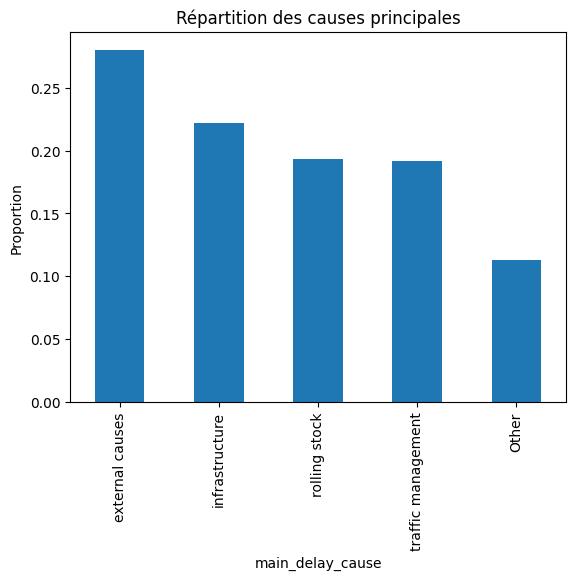

In [99]:
import matplotlib.pyplot as plt

y.value_counts(normalize=True).plot(
    kind="bar", title="Répartition des causes principales"
)
plt.ylabel("Proportion")
plt.show()

## Creation of a pipeline for train the model with valid data

- Use GridSearch with HistGradientBoostingClassifier for find the best hyperprameters

In [100]:
# param_grid = {
#     'classifier__max_iter': [100, 200],
#     'classifier__learning_rate': [0.05, 0.1],
#     'classifier__max_depth': [None, 5, 10]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# print("Best score:", grid_search.best_score_)
# print("Best params:", grid_search.best_params_)

- Use the encoding function and simple imputer methode for smoth the data
- Split the data : train and test

Also use the finded best hyperparameters : `random_state=5, max_iter=100, learning_rate=0.05, max_depth=None`

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

preprocessor = ColumnTransformer(
    transformers=[
        ("date encoding", date_transformer, date_features),
        (
            "categorical encoding",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("imputer", SimpleImputer(strategy="mean")),
        (
            "classifier",
            HistGradientBoostingClassifier(
                random_state=5, max_iter=100, learning_rate=0.05, max_depth=None
            ),
        ),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=5)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('date encoding',
                                                  FunctionTransformer(func=<function extract_date_features at 0x71a1fdc1f7e0>),
                                                  ['Date']),
                                                 ('categorical encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Departure station',
                                                   'Arrival station',
                                                   'Route'])])),
                ('imputer', SimpleImputer()),
                ('classifier',
                 HistGradientBoostingClassifier(learning_rate=0.05,
                                                random_state=5))])

- Print the proportion in the different categories after fusion

In [102]:
print(y.value_counts(normalize=True))

main_delay_cause
external causes       0.280252
infrastructure        0.222269
rolling stock         0.193277
traffic management    0.191457
Other                 0.112745
Name: proportion, dtype: float64


## Evaluation of the comments model

- Use many classifier metrics for display the model precision -> `Accuracy, Precision_score, recall and f1`

In [103]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro", zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average="macro", zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average="macro", zero_division=0))

Accuracy: 0.4084033613445378
Precision: 0.38980693564511426
Recall: 0.36807001031325987
F1 Score: 0.3620989247710809


### Trying of the model

- Try the model with `Nantes -> Paris in 08 2021`

In [104]:
example = pd.DataFrame(
    [
        {
            "Date": "2021-08",
            "Departure station": "NANTES",
            "Arrival station": "PARIS MONTPARNASSE",
            "Route": "NANTES → PARIS MONTPARNASSE",
        }
    ]
)
print("Cause prédite :", pipeline.predict(example)[0])

Cause prédite : infrastructure


## Saving of the model

- Finally save the model in `comments_model.pkl` for it can be used in the dashboard

In [105]:
import joblib

joblib.dump(pipeline, "comments_model.pkl")
print("The comment model is save")

The comment model is save
